In [1]:
import os
import pandas as pd
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.python.keras.applications import vgg16
from tensorflow.python.keras.applications import vgg19
from tensorflow.python.keras.applications import xception
from tensorflow.keras.optimizers import RMSprop
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
pre_trained_model = InceptionV3(input_shape=(150, 150, 3),
                              include_top=False,
                              weights=None)

last_layer = pre_trained_model.get_layer('mixed10')
last_output = last_layer.output

x = layers.Flatten()(last_output)
#x = layers.Dense(1024, activation='relu')(x)
x = layers.Dense(2, activation='sigmoid')(x)

model = Model(pre_trained_model.input, x)

model.compile(optimizer=RMSprop(lr=0.001),
            loss='binary_crossentropy',
            metrics=['accuracy'])

In [3]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define our example directories and files
base_dir = 'C:/Users/sdf80/Desktop/data/fruit_classification/fruit3/'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

train_bad_dir = os.path.join(train_dir, 'Renew_Front_side_of_Bad_fruit')
train_normal_dir = os.path.join(train_dir, 'Renew_Front_side_of_Normal_fruit')
validation_bad_dir = os.path.join(validation_dir, 'Renew_Front_side_of_Bad_fruit')
validation_normal_dir = os.path.join(validation_dir, 'Renew_Front_side_of_Normal_fruit')


test_dir = os.path.join(base_dir, 'test')
train_bad_dir = os.path.join(test_dir, 'Renew_Front_side_of_Bad_fruit')
train_normal_dir = os.path.join(test_dir, 'Renew_Front_side_of_Normal_fruit')

test_fnames = os.listdir(test_dir)
train_bad_fnames = os.listdir(train_bad_dir)
train_normal_fnames = os.listdir(train_normal_dir)

In [5]:
# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255.,
                                 rotation_range=360,
                                 width_shift_range = 0.1,
                                 height_shift_range = 0.1,
                                 shear_range=0.2,
                                 #zoom_range=0.2,
                                 horizontal_flip=True,
                                 vertical_flip=True)

# Note that the validation data should not be augmented!
validation_datagen = ImageDataGenerator(rescale=1./255.)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                  batch_size=20,
                                                  class_mode='binary',
                                                  target_size=(150, 150),)
                                                   #color_mode="grayscale")

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = validation_datagen.flow_from_directory(validation_dir,
                                                      batch_size=10,
                                                      class_mode='binary',
                                                      target_size=(150, 150),)#color_mode="grayscale")

Found 896 images belonging to 4 classes.
Found 786 images belonging to 4 classes.


In [6]:
def image_augmentation( base_dir = 'C:/Users/sdf80/Desktop/data/fruit_classification/fruit3/',
                        train_test_dir_ = 'train',
                        normal_dir_ = 'Renew_Front_side_of_Normal_fruit',
                        bad_dir_ = 'Renew_Front_side_of_Bad_fruit',
                        image_name='aug_data', 
                        iterations = 5,
                        batch_size = 5,
                        rotation_range_=0,
                        width_shift_range_ = 0.0,
                        height_shift_range_ = 0.0,
                        shear_range_=0.0,
                        horizontal_flip_=False,
                        vertical_flip_=False,
                        IsWriteImage = True,
                        IsShowImage= False):
    
    train_test_dir = os.path.join(base_dir, train_test_dir_)
    normal_dir = os.path.join(train_test_dir, normal_dir_)
    bad_dir = os.path.join(train_test_dir, bad_dir_)
    
    datagen = ImageDataGenerator(rescale=1./255.,
                                 rotation_range=rotation_range_,
                                 width_shift_range = width_shift_range_,
                                 height_shift_range = height_shift_range_,
                                 shear_range=shear_range_,
                                 #zoom_range=0.2,
                                 horizontal_flip=horizontal_flip_,
                                 vertical_flip=vertical_flip_)
    generator = datagen.flow_from_directory(train_test_dir,
                                            batch_size=batch_size,
                                            class_mode='binary',
                                            target_size=(150, 150))
    images = []
    for i in range(iterations):
        img, label = generator.next()
        #if(len(label) == iterations):
        if(IsShowImage):        
            n_img = len(label)
            base = cv2.cvtColor(img[0], cv2.COLOR_RGB2BGR)
            for idx in range(n_img - 1):
                img2 = cv2.cvtColor(img[idx + 1], cv2.COLOR_RGB2BGR)
                base = np.hstack((base, img2))
            images.append(base)
        if(IsWriteImage): 
            img = img * 255
            for j in range(len(label)):
                k = i + j
                if (label[j] == 1):
                    final_img = cv2.cvtColor(img[j], cv2.COLOR_RGB2BGR)
                    data_dir = os.path.join(normal_dir, f'{image_name}_{k}.jpg')
                    cv2.imwrite(data_dir, final_img)
                else:
                    final_img = cv2.cvtColor(img[j], cv2.COLOR_RGB2BGR)
                    data_dir = os.path.join(bad_dir, f'{image_name}_{k}.jpg')
                    cv2.imwrite(data_dir, final_img)
        
    if(IsShowImage):
        img = images[0]
        for idx in range(len(images) - 1):
            img = np.vstack((img, images[idx + 1]))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        fig = plt.figure(figsize=(30,10))
        plt.imshow(img)

In [6]:
image_augmentation(train_test_dir_ = 'train',image_name='aug_width_data',
                        iterations = 30,
                        batch_size = 20,
                        rotation_range_=360,
                        width_shift_range_ = 0.1,
                        horizontal_flip_=True,
                        vertical_flip_=True)

Found 434 images belonging to 2 classes.


In [7]:
image_augmentation(train_test_dir_ = 'train',image_name='aug_height_data',
                        iterations = 30,
                        batch_size = 20,
                        rotation_range_=360,
                        height_shift_range_ = 0.1,
                        horizontal_flip_=True,
                        vertical_flip_=True)

Found 441 images belonging to 2 classes.


In [15]:
x,y = next(train_generator)

print(y)

[0. 1. 1. 1. 1. 0. 0. 1. 1. 1. 0. 0. 1. 0. 1. 0. 1. 0. 1. 0.]


In [23]:
history = model.fit_generator(
    train_generator,
    validation_data=validation_generator,
    steps_per_epoch=10,
    epochs=10,
)

Epoch 1/10
10/10 [==============================] - 45s 5s/step - loss: -75.6887 - accuracy: 0.2704 - val_loss: -57.5289 - val_accuracy: 0.2583
Epoch 2/10
10/10 [==============================] - 44s 4s/step - loss: -180.9762 - accuracy: 0.2650 - val_loss: -960.0417 - val_accuracy: 0.2583
Epoch 3/10
10/10 [==============================] - 44s 4s/step - loss: -242.1855 - accuracy: 0.3100 - val_loss: -160.8202 - val_accuracy: 0.2583
Epoch 4/10
10/10 [==============================] - 46s 5s/step - loss: -272.0189 - accuracy: 0.2755 - val_loss: -29.5137 - val_accuracy: 0.2583
Epoch 5/10
10/10 [==============================] - 47s 5s/step - loss: -352.2037 - accuracy: 0.3000 - val_loss: -190.4568 - val_accuracy: 0.2583
Epoch 6/10
10/10 [==============================] - 47s 5s/step - loss: -213.2674 - accuracy: 0.2750 - val_loss: -259.9512 - val_accuracy: 0.2583
Epoch 7/10
10/10 [==============================] - 49s 5s/step - loss: -444.6027 - accuracy: 0.2850 - val_loss: -288.9111 - va

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

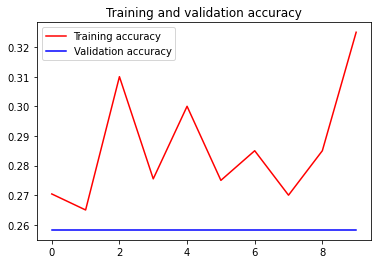

<Figure size 432x288 with 0 Axes>

In [25]:
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

In [48]:
test_fnames
test_fnames2 = os.listdir(base_dir + 'MixData_File')
test_df=pd.DataFrame( {"filename":test_fnames2} )      
test_df

,filename
0,f0.jpg
1,f1.jpg
2,f10.jpg
3,f100.jpg
4,f101.jpg
...,...
429,f95.jpg
430,f96.jpg
431,f97.jpg
432,f98.jpg


In [44]:
nbsamples=test_df.shape[0]

test_datagen=ImageDataGenerator(rescale=1./255)
# 테스트 이미지니까, 사진 그대로 씀
test_generator=test_datagen.flow_from_dataframe(
    test_df,
    base_dir+"MixData_File",
    x_col= "filename",
    y_col= None,
    target_size = (150, 150),
    class_mode = None,
    batch_size = 20,
    shuffle = True)

Found 434 validated image filenames.


In [45]:
predict=model.predict(test_generator, 
                                steps=nbsamples/20)
                                
test_df['category']=np.argmax(predict, axis=1)

In [46]:
test_df.head(434)

,filename,category
0,f0.jpg,0
1,f1.jpg,0
2,f10.jpg,0
3,f100.jpg,0
4,f101.jpg,0
...,...,...
429,f95.jpg,0
430,f96.jpg,0
431,f97.jpg,0
432,f98.jpg,0


In [47]:
test_df.to_csv("category.csv")

In [39]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras import datasets, layers, models
Ann_model = models.Sequential()
Ann_model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
Ann_model.add(layers.MaxPooling2D((2, 2)))
Ann_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
Ann_model.add(layers.MaxPooling2D((2, 2)))
Ann_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
Ann_model.add(layers.MaxPooling2D((2, 2)))
Ann_model.add(layers.Flatten())
Ann_model.add(layers.Dense(64, activation='relu'))
Ann_model.add(layers.Dense(1, activation='sigmoid'))

Ann_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
Ann_model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_117 (Conv2D)          (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_118 (Conv2D)          (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_119 (Conv2D)          (None, 34, 34, 64)        36928     
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 17, 17, 64)        0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 18496)           

In [40]:
history = Ann_model.fit_generator(
    train_generator,
    validation_data=validation_generator,
    steps_per_epoch=10,
    epochs=10,
)

Epoch 1/10
10/10 [==============================] - 11s 1s/step - loss: -78.2513 - accuracy: 0.2700 - val_loss: -317.6707 - val_accuracy: 0.2583
Epoch 2/10
10/10 [==============================] - 10s 1s/step - loss: -1513.5511 - accuracy: 0.2750 - val_loss: -4955.8252 - val_accuracy: 0.2583
Epoch 3/10
10/10 [==============================] - 9s 938ms/step - loss: -17366.5469 - accuracy: 0.2850 - val_loss: -34758.1875 - val_accuracy: 0.2583
Epoch 4/10
10/10 [==============================] - 9s 946ms/step - loss: -66954.0234 - accuracy: 0.2950 - val_loss: -165779.6406 - val_accuracy: 0.2583
Epoch 5/10
10/10 [==============================] - 10s 994ms/step - loss: -344272.1875 - accuracy: 0.3050 - val_loss: -581172.8750 - val_accuracy: 0.2583
Epoch 6/10
10/10 [==============================] - 10s 1s/step - loss: -814264.3750 - accuracy: 0.2800 - val_loss: -1825165.5000 - val_accuracy: 0.2583
Epoch 7/10
10/10 [==============================] - 10s 952ms/step - loss: -2745505.7500 - acc

In [41]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

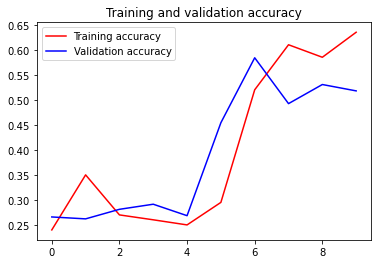

<Figure size 432x288 with 0 Axes>

In [38]:
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

In [31]:

test_fnames2 = os.listdir(base_dir + 'MixData_File')
test_df=pd.DataFrame( {"filename":test_fnames2} )      

nbsamples=test_df.shape[0]

test_datagen=ImageDataGenerator(rescale=1./255)
# 테스트 이미지니까, 사진 그대로 씀
test_generator=test_datagen.flow_from_dataframe(
    test_df,
    base_dir+"MixData_File",
    x_col= "filename",
    y_col= None,
    target_size = (150, 150),
    class_mode = None,
    batch_size = 20,
    shuffle = True)

Found 19 validated image filenames.


In [32]:
predict=Ann_model.predict(test_generator, 
                                steps=nbsamples/10)
                                
test_df['category']=np.argmax(predict, axis=1)

In [33]:
test_df.to_csv("category.csv")